In [ ]:
using Pkg, Revise
gen_la_pb_dir = "../GenLinAlgProblems"
Pkg.activate(gen_la_pb_dir)
# cd into GenLinAlgProblems, start julia, and add the package to dev:   pkg> dev .
using GenLinAlgProblems, LinearAlgebra, RowEchelon, Latexify, SymPy, Random

using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix")

include(gen_la_pb_dir * "/src/ge.jl");  # wrapper for nM.ge

<div style="height:2cm;">
<div style="float:center;width:100%;text-align:center;"><strong style="height:100px;color:darkred;font-size:40px;">Cholesky Decomposition</strong>
</div></div>

# 1. The Decomposition of Symmetric Matrices

Consider the following Gaussian Elimination Example for a **symmetric matrix**

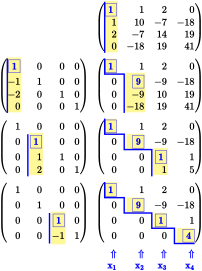

In [190]:
Random.seed!(2323)
N = 4
L,D,A=gen_ldlt_pb(N;maxint=3,squares=true)
matrices, pivot_cols, desc = reduce_to_ref( A; gj=false )
ge( matrices, desc, pivot_cols; tmp_dir="/tmp" )

LU decomposition: A = 


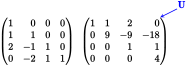

In [192]:
println( "LU decomposition: A = " )
h,_= nM.ge( to_latex([[(L), matrices[end][end] ]]), formater=x->x, array_names=["L",["U"]])
h

The matrix is **symmetric**, but this is **not obvious** from the LU decomposition.

## 1.1 The PLDU Decomposition

Given a PLU decomposition of a matrix $A$ of size $M \times N$, we can choose to pull the pivots out of $U$,<br>$\qquad$
i.e., let $D^{-1}$ be the scaling matrix that reduces the pivots of $U$ to 1, and compute $P L D \left( D^{-1} U\right)$.<br>$\qquad$
Renaming $D^{-1} U$ to $U$, we have obtained the **PLDU decomposition**.

We can do this for any size matrix $A$, but let's apply this decomposition to our symmetric matrix example:

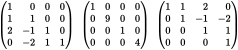

In [194]:
D    = Diagonal(matrices[end][end])             # the matrix with the pivots on the diagonal
Dinv = D^-1                                     # the inverse of D
U    = Int.(round.(Dinv*matrices[end][end]))    # the renamed U matrix

h,_  = nM.ge( to_latex([[L, D, U]]), formater=x->x)
h

We see that $U = L^t$, so that $A = L D L^t$.

## 1.2 The $L D L^t$ Decomposition

#### Idea: apply $E_i$ from the right and $E_i^t$ from the left to a symmetric matrix

For a symmetric matrix $A$, row $i$ is equal to column $i$. If we compute the matrix $E_i A$ to zero out entries below the diagonal,<br>
we can zero out the entries to the right of the diagonal by computing $E_i A E_i^t$. The resulting matrix is again symmetric.

Let's apply this to our example $A = L D U$, for each of the elimination matrices:

Reverting Windows console CPs to (in,out) = (437,437)


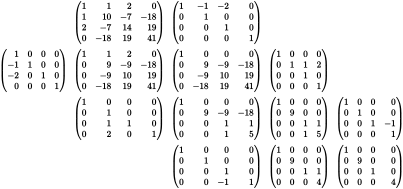

In [195]:
E1=matrices[2][1];E2=matrices[3][1];E3=matrices[4][1]

matricesLDLT = [
    [:none,      A,         E1',               :none,                  :none],
    [ E1,     E1*A,    E1*A*E1',                 E2',                  :none],
    [ :none,    E2, E2*E1*A*E1',     E2*E1*A*E1'*E2',                    E3'],
    [ :none, :none,         E3 ,  E3*E2*E1*A*E1'*E2', E3*E2*E1*A*E1'*E2'*E3'],
]
h,_=nM.ge( to_latex(matricesLDLT), formater=x->x, fig_scale=0.9 )
h

As we see, this reduces the symmetric matrix to the $D$ matrix.

----
What if pivots are missing?

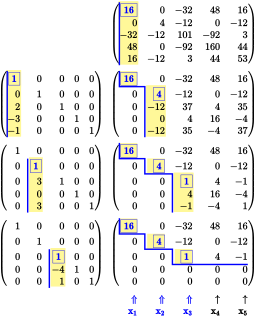

In [197]:
Random.seed!(2422)
N=5;r=3

L,D,A = gen_ldlt_pb(N;maxint=4, rank=r,squares=true)
matrices, pivot_cols, desc = reduce_to_ref( A; gj=false )
ge( matrices, desc, pivot_cols; tmp_dir="/tmp" )

Again, applying the elimination to rows and columns, we see that the matrix reduces to a diagonal matrix: 

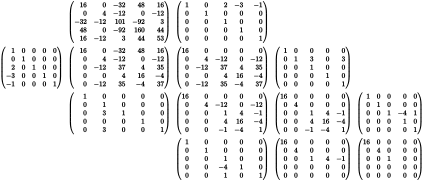

In [201]:
E1=matrices[2][1];E2=matrices[3][1];E3=matrices[4][1]

matricesLDLT = [
    [:none,      A,         E1',               :none,                  :none],
    [ E1,     E1*A,    E1*A*E1',                 E2',                  :none],
    [ :none,    E2, E2*E1*A*E1',     E2*E1*A*E1'*E2',                    E3'],
    [ :none, :none,         E3 ,  E3*E2*E1*A*E1'*E2', E3*E2*E1*A*E1'*E2'*E3'],
]
h,_=nM.ge( to_latex(matricesLDLT), formater=x->x, fig_scale=0.7 )
h

Note the zero rows and columns. If $r = 3$, i.e., if $r$ is the number of pivots, we can reduce the
matrices to $A = L_r D_r L_r^t$,<br>$\quad$
where $L_r$ consists of the first $r$ columns of $L$, and $D_r$ is the submatrix of the first $r$ rows and columns of $D$.

In [202]:
Lᵣ = L[:,1:r]
Dᵣ  = matricesLDLT[end][end][1:r,1:r]
latexify([Lᵣ',Dᵣ',Lᵣ]')

L"\begin{equation}
\left[
\begin{array}{ccc}
\left[
\begin{array}{ccc}
1 & 0 & 0 \\
0 & 1 & 0 \\
-2 & -3 & 1 \\
3 & 0 & 4 \\
1 & -3 & -1 \\
\end{array}
\right] & \left[
\begin{array}{ccc}
16 & 0 & 0 \\
0 & 4 & 0 \\
0 & 0 & 1 \\
\end{array}
\right] & \left[
\begin{array}{ccccc}
1 & 0 & -2 & 3 & 1 \\
0 & 1 & -3 & 0 & -3 \\
0 & 0 & 1 & 4 & -1 \\
\end{array}
\right] \\
\end{array}
\right]
\end{equation}
"

In [203]:
println("Let's check: A - Lᵣ Dᵣ Lᵣᵗ = ")
Int.(A - Lᵣ * Dᵣ * Lᵣ')

Let's check: A - Lᵣ Dᵣ Lᵣᵗ = 


5×5 Matrix{Int64}:
 0  0  0  0  0
 0  0  0  0  0
 0  0  0  0  0
 0  0  0  0  0
 0  0  0  0  0

#### What if we require a row exchange?

Unfortunately, this messes thing up! Look at the matrix
$$
A = \begin{pmatrix} 0 & 1 & 0 \\ 1 & 0 & 1 \\ 0 & 1 & 0 \end{pmatrix}
$$

It requires a row exchange. To maintain the symmetry, we would need to compute $P A P^t$, where $P$ is a permutaion matrix:

In [204]:
A = [ 0 1 0; 1 0 1; 0 1 0]
P = [ 0 1 0; 1 0 0; 0 0 1]
latexify( [P', P*A*P']')

L"\begin{equation}
\left[
\begin{array}{cc}
\left[
\begin{array}{ccc}
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1 \\
\end{array}
\right] & \left[
\begin{array}{ccc}
0 & 1 & 1 \\
1 & 0 & 0 \\
1 & 0 & 0 \\
\end{array}
\right] \\
\end{array}
\right]
\end{equation}
"

If we try to move a pivot into position $(1,1)$ with some matrix $P$,<br>$\qquad$
the subsequent multiplication with $P^t$ from the right will immediately move it back out!

No matter what we try, we cannot get $A = L D L^t$ for this example!

____
**Theorem:** A symmetric matrix $A \in \mathbb{R}^{N \times N}$ has an $L D L^t$ decomposition<br>$\qquad$
iff it can be reduced to row echelon form **without row exchanges.**

We will not concern ourselves with the extension to complex numbers here.

**Remark:** If the given symmetric matrix $A \in \mathbb{R}^{N \times N}$, with $L D L^t$ decomposition $A = L D L^t$<br>$\qquad$
has $r$ pivots with $r < N$, we can remove the zero rows and columns<br>$\qquad$ to get $A = L_r D_r L_r^t$,$\quad$ at the price that $L_r$ is
no longer square (and hence not invertible).

# 2. The Cholesky Decomposition

## 2.1. The Decomposition

Consider the special case where the symmetric matrix $A = L D L^t$ of size ${N \times N}$ has only positive pivots.<br>$\qquad$
(Such a matrix will be called **positive definite**). We can split the matrix $D$ into two by setting $D = \tilde{D} \tilde{D}$,<br>$\qquad$
where $\tilde{D}$ has the squareroots of the pivots of $D$ on the diagonal.

We see that $A = \left( L \tilde{D} \right) \left( \tilde{D} L^t \right) = G G^t$, where we have set $G = L \tilde{D}$.

#### Consider the first Example

We can compute $G$ by adding another step to Gaussian Elimination, namely scaling the pivots to their square roots:

In [221]:
Random.seed!(2323)
N = 4
L,D,A=gen_ldlt_pb(N;maxint=4, squares=true)
inv_sqrt_D = Diagonal((x->1//x).(Int.(round.(sqrt(D)))))  # the pivots all happen to be perfect squares)
latexify( inv_sqrt_D )

L"\begin{equation}
\left[
\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & \frac{1}{4} & 0 & 0 \\
0 & 0 & \frac{1}{2} & 0 \\
0 & 0 & 0 & \frac{1}{3} \\
\end{array}
\right]
\end{equation}
"

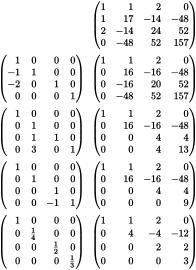

In [223]:
matrices, pivot_cols, desc = reduce_to_ref( A; gj=false )
push!( matrices, [ inv_sqrt_D, inv_sqrt_D*matrices[end][end] ])
h,_=nM.ge( to_latex(matrices), formater=x->x, tmp_dir="/tmp" )
h

In [226]:
println( "therefore A = G G', where G =" )
latexify(Int.(matrices[end][end]'))

therefore A = G G', where G =


L"\begin{equation}
\left[
\begin{array}{cccc}
1 & 0 & 0 & 0 \\
1 & 4 & 0 & 0 \\
2 & -4 & 2 & 0 \\
0 & -12 & 2 & 3 \\
\end{array}
\right]
\end{equation}
"

**Remark** If $A = L D L^t$ has fewer pivots than columns, i.e., if $A = L_r D_r L_r^t \;\;$ with $r<N$<br>$\qquad$
we can still get $A = G_r G_r^t$, with $G_r = L_r D_r^{\tfrac{1}{2}} \;\;$ when the pivots in $D_r$ are positive<br>$\qquad$
although the matrix $G_r is no longer square.
    
Such a matrix will be said to be **positive semi_definite**

**Remark:** given $A = G G^t$, we can solve $A x = b \Leftrightarrow \left\{ \begin{align} G &y = b \\ G^t &x = y \end{align}\right.\qquad$
using forward/backward substitution.

## 2.2 Computation of the Cholesky Decomposition

Given a positive matrix $A = G G^t$, we can take advantage of the symmetry to directly compute $G$.

Comparing the entries in $A$ to the entries in $G G'$ for
$$
G = \begin{pmatrix} g_{1 1} & 0       & \dots \\
                    g_{2 1} & g_{2 2} & \dots \\
                    \dots   & \dots   & \dots \end{pmatrix}
$$
yields a set of non-linear equations that are readily solved.

**Doing so is about twice as fast as the Gaussian Elimination Algorithm!**

> Look at
https://towardsdatascience.com/behind-the-models-cholesky-decomposition-b61ef17a65fb<br>$\qquad$
for two possible applications of this decomposition.